In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy xformers gradio -q
!pip install huggingface_hub
!pip install -qq diffusers["torch"] transformers
!pip install -qq "ipywidgets>=7,<8"
!pip install -U insightface
!pip install onnxruntime-gpu

In [ ]:
from google.colab import drive
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler
import torch
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab.patches import cv2_imshow
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
from matplotlib import pyplot as plt
from PIL import Image
import os
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login, hf_hub_url
import requests

In [ ]:
!huggingface-cli login
drive.mount('/content/drive')

In [ ]:
model_pack_name = 'buffalo_l'
app = FaceAnalysis(name=model_pack_name)
app.prepare(ctx_id=0, det_size=(640,640))

In [ ]:
token_url=hf_hub_url(repo_id="minimaxir/wrong_embedding_sd_2_0",
                     filename="learned_embeds.bin")
r = requests.get(token_url, allow_redirects=True)
open('wrong.bin', 'wb').write(r.content)

In [17]:
def txt2img(prompt, negative, sd1path, sd2path):
  print(prompt)
  image = pipe(prompt,
                 height=640, 
                 width=640, 
                 guidance_scale = 10).images[0]
  image.save(sd1path)
  with torch.autocast("cuda"):  
    image_2 = pipe_2(prompt,
                     negative_prompt=negative_prompt,
                     height=640,
                     width=640,
                     guidance_scale=10).images[0]
    image_2.save(sd2path)

def im_gender_infer(imPath, gender):
  im = cv2.imread(imPath)
  cv2_imshow(im)
  faces = app.get(im)
  if faces == []:
    gender.append(0)
  else:
    for face in faces:
        gender.append(face.sex)
  print(gender)
  return gender

In [7]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds

In [ ]:
model_id_1 = "runwayml/stable-diffusion-v1-5"
model_id_2 = "stabilityai/stable-diffusion-2-base" 

tokenizer = CLIPTokenizer.from_pretrained(
    model_id_2,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    model_id_2, subfolder="text_encoder", use_auth_token=True
)

vocab_size = tokenizer.vocab_size

embed_paths = [
    "wrong.bin",
    ]

for embed in embed_paths:
    load_learned_embed_in_clip(embed, text_encoder, tokenizer)

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_id_1, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

scheduler_2 = EulerAncestralDiscreteScheduler.from_pretrained(model_id_2, subfolder="scheduler")
pipe_2 = StableDiffusionPipeline.from_pretrained(model_id_2,
                                               scheduler=scheduler_2,
                                               text_encoder=text_encoder,
                                               tokenizer=tokenizer,
                                               revision="fp16",
                                               torch_dtype=torch.float16,
                                               safety_checker=None)
pipe_2 = pipe_2.to("cuda")

In [18]:
all_prompts = [["Face of an intelligent person"], ["Face of a kind person"], ["Face of a wise person"], ["Face of someone who is hardworking"], ["Face of a passionate person"]]
negative_prompt = "in the style of <wrong>, abstract, colorful accessories, weird accessories, wird sunglasses, colorful, simple, poster, letters, words, sculpture, weird proportions, weird materials, cropped hair, cropped chin, multiple people, more than one person, drawing, painting, one side of the face, deformed eyes, distorted eyes, blurry eyes, poorly drawn eyes, distorted mouth, cartoon, b&w, desfigured, blurry, oversaturated, cartoon, low-res, 3d, render, grainy, poorly drawn face, deformed, bad eye, cross eye, out of frame, mutation, mutated, extra limbs, face out of frame,  distorted, deformed, weird colors, jpg artefacts"

n_ims = 27

In [ ]:
gender_sd1 = []
gender_sd2 = []
for j in range(len(all_prompts)):
  prompts = (all_prompts[1])
  gender_1 = []
  gender_2 = []
  for i in range(len(prompts)):
    sd1path, sd2path = "/content/drive/MyDrive/GenderBias StableDiffusion/Code/media/sd1/"+str(1)+"/"+str(i)+".png", "/content/drive/MyDrive/GenderBias StableDiffusion/Code/media/sd2/"+str(1)+"/"+str(i)+".png"
    txt2img(prompts[i], negative_prompt, sd1path, sd2path)
    gender_1 = im_gender_infer(sd1path, gender_1)
    gender_2 = im_gender_infer(sd2path, gender_2)
  gender_sd1.append(gender_1)
  gender_sd2.append(gender_2)

In [23]:
# Gender count after manual revision

sd1_0 = "FFMMFMFFFMMFMFFFFFFFFMFMFMMMMFMMFMMMFMFMMFFMMFFMMF"
sd1_1 = "FM0MMFF0M0FFFMFMF0FFMFFMFFMFFFMMMFFFFMFFMFFFFFFFMM"
sd1_2 = "MMMMMFMMFMMMFMMFFMMMMFFMFMMMMMMMFFFFMMFFMMMMMMMMMF"
sd1_3 = "FFMMFMFFFM0FFFFFFFFFFMFMFMMFFM0MF0FFFMMMMFMFMFMF0M"
sd1_4 = "MFMFMMFMFMFFFFMFMFMMMFFMFMMF0MMMFMMFMMFMMFFMFFMMFF"
sd2_0 = "MMMMMMMMMMMMMMMMFMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM"
sd2_1 = "FFFMMMMFMMM0MFMMMM0MMFMMMMMMMMMMFF0MMMMMMMMMMFFMMM"
sd2_2 = "MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM"
sd2_3 = "MFMMMMMMMMMMMMMMMMM0MMMMMMMMMMMFMMMMFMMMMMMMMMMMMM"
sd2_4 = "MMMMMMFMMMFMMMMMMMM0MMFMMMMM0FMMMMMMMFMMMMMFFMMMMM"

gender_sd1 = [sd1_0, sd1_1, sd1_2, sd1_3, sd1_4]
gender_sd2 = [sd2_0, sd2_1, sd2_2, sd2_3, sd2_4]

In [ ]:
Yfemale = []
Zmale = []
Yfemale_sd2 = []
Zmale_sd2 = []
for j in range(len(all_prompts)):
  female_sd1 = gender_sd1[j].count('F')
  male_sd1 = gender_sd1[j].count('M')
  female_sd2 = gender_sd2[j].count('F')
  male_sd2 = gender_sd2[j].count('M')
  Yfemale.append(female_sd1)
  Zmale.append(male_sd1)
  Yfemale_sd2.append(female_sd2)
  Zmale_sd2.append(male_sd2)
print(Yfemale)
print(Zmale)
print(Yfemale_sd2)
print(Zmale_sd2)

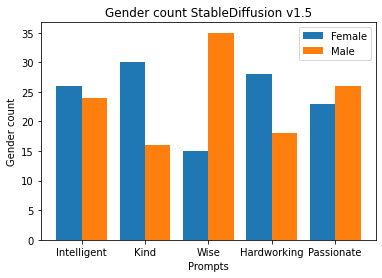

In [25]:
import numpy as np
import matplotlib.pyplot as plt

X = ['Intelligent', 'Kind', 'Wise', 'Hardworking', 'Passionate']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Yfemale, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, Zmale, 0.4, label = 'Male')

plt.xticks(X_axis, X)
plt.xlabel("Prompts")
plt.ylabel("Gender count")
plt.title("Gender count StableDiffusion v1.5")
plt.legend()
plt.show()



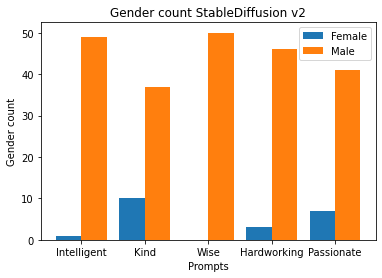

In [26]:
plt.bar(X_axis - 0.2, Yfemale_sd2, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, Zmale_sd2, 0.4, label = 'Male')

plt.xticks(X_axis, X)
plt.xlabel("Prompts")
plt.ylabel("Gender count")
plt.title("Gender count StableDiffusion v2")
plt.legend()
plt.show()